I want to create code for a 1D Hubbard chain ED utilizing only the two $U(1)$ charge/spin symmetries. This is meant to represent a single chain of the eventual system. The chain Hamiltonian is 
$$
\large
H^x = \sum_{\langle ij \rangle \in \mathcal{x}} \sum_s t c^\dagger_{is}c_{js}
$$
and symmetries allow us to work in a fixed 
$$
\large
(n^x_\uparrow,n^x_{\downarrow})
$$
symmetry sector.
The natural decomposition of the hilbert space into spin parts
$$
\large
\mathcal{H}^x = \otimes_s\mathcal{H}^x_s
$$
simplifies the basis construction:

---------------------------
Basis Construction
----------------
Each spin hilbert space at each site has a dimension of two: empty or occupied which naturally lends itself to a binary representation. For N sites, the $\uparrow$ basis is labelled by N digit binaries with base 10 rep between $0$ and $2^N-1$. Same with the $\downarrow$ basis. A state with reps for $\uparrow,\downarrow = (i,j)$ will have a total ordering $2^N \times i + j$ so total basis is characterized by numbers between $0$ and $4^N-1$. However, since we are working in a $(n^x_\uparrow,n^x_{\downarrow})$ sector, really we will have an ordering 
$$
\large
(i,j) \rightarrow \begin{pmatrix} N \\ n^x_\uparrow\end{pmatrix}\times i + j
$$
and a basis going between 
$$
\large
0 :\begin{pmatrix} N \\ n^x_\uparrow\end{pmatrix}\begin{pmatrix} N \\ n^x_\downarrow\end{pmatrix} -1
$$
--------------------------------
Number of sections
---------------------
For a chain of $N$ sites there can be between $0$ and $N$ $\uparrow$ electrons and same for the $\downarrow$ electrons, hence there are 
$(N+1)^2$ fixed $(n^x_\uparrow,n^x_{\downarrow})$ sections.

-------------------------------------------
Lin Table
--------------
In essence, for an integer $I$ representing a basis state $|s\rangle$, we want a table (map) $T$ between the state $I$ and its basis number $J$:
$$
T : J \rightarrow I

$$
$$
T(J) = I
$$
where $I \in [0,2^N-1]$ and $J \in [0,\#_\text{basis}]$
Since we have naturally split up the integer representation
$$
I = I_\uparrow + 2^N I_\downarrow
$$
we define two tables (maps)
$$
J_\uparrow(I_\uparrow),J_\downarrow(I_\downarrow)
$$
with the final mapping $I \rightarrow J$ being
$$
J = J_\uparrow+J_\downarrow
$$
So the flow is:
$$
I \rightarrow I_\uparrow,I_\downarrow \rightarrow J 
$$
or, if we start off from J, we go instead:
$$
J \rightarrow I = T(J)
$$
----------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spst
from scipy.sparse import csr_matrix,coo_matrix #optimizes H . v operations. to check if H already row sparse, do  isspmatrix_csr(H)
from scipy.sparse.linalg import eigsh
import time
import pickle

In [93]:
def countBits(x):
    '''Counts number of 1s in bin(n)'''
    #From Hacker's Delight, p. 66
    x = x - ((x >> 1) & 0x55555555)
    x = (x & 0x33333333) + ((x >> 2) & 0x33333333)
    x = (x + (x >> 4)) & 0x0F0F0F0F
    x = x + (x >> 8)
    x = x + (x >> 16)
    return x & 0x0000003F 
def binp(num, length=4):
    '''
    print a binary number without python 0b and appropriate number of zeros
    regular bin(x) returns '0bbinp(x)' and the 0 and b can fuck up other stuff
    '''
    return format(num, '#0{}b'.format(length + 2))[2:]
def basisVisualizer(L,psi):
    '''
    Given psi=(#)_10, outputs the state in arrows
    (psi is the decimal number not its binary rep)
    '''
    #ex: |↓|↑|↓|↑|↑|
    psi_up = psi%(2**L)
    psi_down = psi//(2**L)

    s_up = bin(psi_up)[2:]
    s_down = bin(psi_down)[2:]
    N_up  = len(s_up)
    N_down = len(s_down)
    up = (L-N_up)*'0'+s_up
    down = (L-N_down)*'0'+s_down
    configStrUp = ""
    configStrDown = ""
    configStr = ""
    uparrow   = '\u2191'
    downarrow = '\u2193'
    empty = 'o'
    for i in range(L):
        blank = True
        if up[i] == '1' and down[i] == '1':
            configStr += '('+uparrow+downarrow+')'
            blank = False
        if up[i] == '1' and down[i] == '0':
            configStr +=uparrow
            blank = False
        if up[i] == '0' and down[i] == '1':
            configStr +=downarrow
            blank = False
        if up[i] == '0' and down[i] == '0':
            configStr += empty
            blank = False
        if blank:
            configStr+="_"
    print(configStr)
    return
def symmsector(L,psi,Q1,Q2):
    '''
    ''' 
    psi_up = psi%(2**L)
    psi_down = psi//(2**L)

    #s_up = binp(psi_up)
    #s_down = binp(psi_down)
    #print(s_up,s_down)
    if countBits(psi_up) == Q1 and countBits(psi_down) == Q2:
        return True
def symmsectorTot(L,psi,Q):
    '''
    ''' 
    psi_up = psi%(2**L)
    psi_down = psi//(2**L)

    #s_up = binp(psi_up)
    #s_down = binp(psi_down)
    #print(s_up,s_down)
    if countBits(psi_up)+countBits(psi_down) == Q:
        return True
def basis_0(L,Q1,Q2):
    states = []
    for I in range(4**L):
        if symmsector(L,I,Q1,Q2):
            states.append(I)
    return states, len(states)
def basis_00(L,Q1,Q2):
    ''' 
    generates Lin lookup tables
    '''
    states = []
    J_up = {}
    J_down = {}
    J = 0
    for I_down in range(2**L):
        if countBits(I_down) == Q2:
            count = 0
            for I_up in range(2**L):
                if countBits(I_up) == Q1:
                    ###
                    J_up[I_up] = count
                    J_down[I_down] = J - J_up[I_up]
                    ###
                    states.append(I_up+I_down*2**L)
                    count +=1
                    J += 1
    return states, len(states),J_up,J_down,J
def basis_tot(L,Q):
    states = []
    for I in range(4**L):
        if symmsectorTot(L,I,Q):
            states.append(I)
    return states, len(states)
def basis_1(L,Q1,Q2):
    '''
    creates basis recurseively. probably not important if we are working at the level of the chain since there L=2-4 only. 
    '''
    states = []
    psi_up_init = 2**(Q1)-1
    psi_down_init = 2**(Q2)-1
    psi_up = psi_up_init
    psi_down = psi_down_init
    s = psi_up + psi_down*2**L
    while True:
        Bup = countBits(psi_up) == Q1
        Bdown = countBits(psi_down) == Q2
        if Bup and Bdown:
            states.append(s)
        #now the next step is to look from mzstategenerator2 function and move 1's to the left for both up and down spins to create states of same (n_ip,n_down) sector.

def flip(s,i,j):
    '''
    given an integer s, flip its binary elements at indices i,j and return new integer s'
    ---------------------------------------------------------------------------------------
    Do this by creating a mask that is non-zero only at affected sites, and do XOR with our state. 
    so one site has  T T -> F (full goes to empty) and other has F T -> T (empty goes full)
    '''
    mask = 2**(i)+2**(j)
    s = s^mask 
    return s

def hop(I1,i,j):
    '''
    if hopping is allowed, outputs integer I2 that it maps to.
    This is for a single spin
    '''
    mask = 2**(i)+2**(j)
    K = I1 & mask #bitwise AND.
    L = K ^ mask #bitwise XOR.
    # L will have structure 0000000[i]0000[j]00000 and there's four cases:
    #1) L = mask means I1[i]=I1[j]=0 -> hopping is not allowed
    #2) L = 000..00 means I1[i]=I1[j]=1 -> hopping is not allowed
    #3&4) L = ...[1]...[0]... or L = ...[0]...[1]... means hopping is allowed, in which case new integer is 
    if L == mask or L == 0:
        #print('no hop')
        I2 = -1#flag to signify no hopping
    else:
        I2 = I1 - K + L
    return I2
########################################################################
def hop_spinful(L,states,m,i,j,J_down,J_up):
    ''' 
    m: basis index 
    out: n basis index
    '''
    print('og state')
    print('--------------')
    basisVisualizer(L=L,psi=states[m])
    print('--'*10)
    print('derived states:')
    psi =  states[m]
    psi_up = psi%(2**L)
    psi_down = psi//(2**L)
    nup = J_up[psi_up]
    ndown = J_down[psi_down]
    psi_up_prime = hop(psi_up,i,j)
    psi_down_prime = hop(psi_down,i,j)
    ns = []
    if psi_up_prime!= -1:
        #print(psi_up_prime)
        nup_prime = J_up[psi_up_prime]
        ns.append(nup_prime + ndown)
        basisVisualizer(L=L,psi=psi_up_prime+psi_down*2**L)
        print('-'*10)
    if psi_down_prime!= -1:
        #print(psi_down_prime)
        ndown_prime = J_down[psi_down_prime]
        ns.append(nup + ndown_prime)
        basisVisualizer(L=L,psi=psi_up+psi_down_prime*2**L)
        print('-'*10)
    return ns
def double_occupancy(L,psi,i):
    '''
    counts number of electrons at site i.
    if psi AND mask == mask that means psi at site i has both up and down electrons
    '''
    mask = 2**(i)+2**(L+i)
    if (psi & mask) == mask:
        return 1
    else:
        return 0
def occupancy(L,psi,i):
    mask = 2**(i)+2**(L+i)
    occ = countBits(psi & mask)
    return occ
    
def hamiltonian_section_full(parameters):
    ############################
    #0) read parameters
    Q_up = parameters['Electrons_up']
    Q_down = parameters['Electrons_down']
    L = parameters['L']
    t = parameters['hop']
    mu = parameters['mu']
    U = parameters['int']
    mu_eff = mu+0.5*U
    mu_eff = mu
    ############################
    #1) create basis
    states, M,J_up,J_down,J = basis_00(L=L,Q1=Q_up,Q2=Q_down)
    #2) build Hamiltonian
    H = np.zeros((M,M),dtype=float)
    for m in range(M):
        state = states[m]
        for i in range(L):
            j = (i+1)%L
            #############
            #interaction#
            ######&######
            ##chem pot###
            #############
            occ = occupancy(L,state,i)
            if occ == 2:
                H[m,m] += U
            H[m,m] -= mu_eff*occ
            #############
            ###hopping###
            #############
            psi_up = state%(2**L)
            psi_down = state//(2**L)
            nup = J_up[psi_up]
            ndown = J_down[psi_down]
            psi_up_prime = hop(psi_up,i,j)
            psi_down_prime = hop(psi_down,i,j)
            if psi_up_prime!= -1:
                nup_prime = J_up[psi_up_prime]
                H[m,nup_prime + ndown] -= t
            if psi_down_prime!= -1:
                ndown_prime = J_down[psi_down_prime]
                H[m,nup + ndown_prime] -= t
    print(np.all(H==H.T))
    return H 

In [142]:
L = 4
for n_up in np.arange(0,L+1):
    for n_down in np.arange(0,L+1):
        if n_up + n_down != L: continue
        print(n_up,n_down)

0 4
1 3
2 2
3 1
4 0


In [132]:
parameters = {}
parameters['Electrons_up'] = 2
parameters['Electrons_down'] = 2
parameters['L'] = 4
parameters['mu'] = 2
parameters['int'] = 5
parameters['hop'] = 1
H2 = hamiltonian_section_full(parameters=parameters)

True


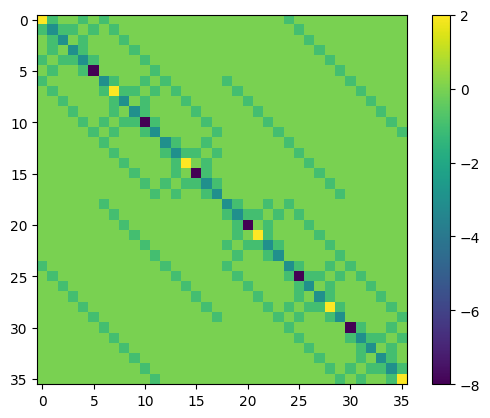

In [140]:
plt.imshow(H2)
plt.colorbar()

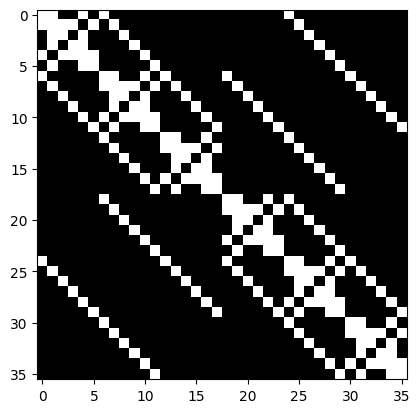

In [133]:
boolean_matrix = (H2 != 0)
plt.imshow(boolean_matrix, cmap='grey', interpolation='nearest')

In [134]:
states, l,J_up,J_down,J = basis_00(4,2,2)


In [137]:
basisVisualizer(4,states[35])

(↑↓)(↑↓)oo


In [16]:
basisVisualizer(L=3,psi=states[0])

o↑(↑↓)


In [8]:
print(states)

[11, 13, 14, 19, 21, 22, 35, 37, 38]


In [9]:
for k in J_up.keys():
    for l in J_down.keys():
        print((k,J_up[k]+1),(l,J_down[l]+1),J_up[k]+J_down[l]+1)
        print('-'*10)

(3, 1) (1, 1) 1
----------
(3, 1) (2, 4) 4
----------
(3, 1) (4, 7) 7
----------
(5, 2) (1, 1) 2
----------
(5, 2) (2, 4) 5
----------
(5, 2) (4, 7) 8
----------
(6, 3) (1, 1) 3
----------
(6, 3) (2, 4) 6
----------
(6, 3) (4, 7) 9
----------


In [10]:
J_down

{1: 0, 2: 3, 4: 6}

In [53]:
for i in range(10):
    hop_spinful(L=10,states = states,m = 2,i = i,j = (i+1)%10,J_down = J_down,J_up = J_up)

og state
--------------
ooooooo↑↑↓
--------------------
derived states:
ooooooo↑o(↑↓)
----------
ooooooo↑(↑↓)o
----------
og state
--------------
ooooooo↑↑↓
--------------------
derived states:
og state
--------------
ooooooo↑↑↓
--------------------
derived states:
oooooo↑o↑↓
----------
og state
--------------
ooooooo↑↑↓
--------------------
derived states:
og state
--------------
ooooooo↑↑↓
--------------------
derived states:
og state
--------------
ooooooo↑↑↓
--------------------
derived states:
og state
--------------
ooooooo↑↑↓
--------------------
derived states:
og state
--------------
ooooooo↑↑↓
--------------------
derived states:
og state
--------------
ooooooo↑↑↓
--------------------
derived states:
og state
--------------
ooooooo↑↑↓
--------------------
derived states:
↓oooooo↑↑o
----------


In [21]:
basisVisualizer(L=3,psi=states[0])

o↑(↑↓)


In [25]:
basisVisualizer(L=3,psi=states[13])

IndexError: list index out of range

In [24]:
hop(states[0],2,1)

13

In [99]:
test = {}
len(test)
test['a'] = 1
test['b'] = 2
len(test)

2

In [95]:
basis_tot(L=3,Q=3)

([7,
  11,
  13,
  14,
  19,
  21,
  22,
  25,
  26,
  28,
  35,
  37,
  38,
  41,
  42,
  44,
  49,
  50,
  52,
  56],
 20)

In [75]:
basis_0(L=L,Q1=2,Q2 = 1)

([11, 13, 14, 19, 21, 22, 35, 37, 38], 9)

In [76]:
L =2
psi = 2
psi_up = psi%(2**L)
psi_down = psi//(2**L)
print(psi_up,psi_down)

2 0


In [84]:
X = countBits(psi_up) == 1
Y = countBits(psi_up) == 0

In [85]:
X and Y

False

In [70]:
L = 3
for I in range(0,4**L):
    #print(I)
    #basisVisualizer(L=L,psi=I)
    if symmsector(L,I,2,1):
        basisVisualizer(L=L,psi=I)
        print('-'*10)

o↑(↑↓)
----------
↑o(↑↓)
----------
↑↑↓
----------
o(↑↓)↑
----------
↑↓↑
----------
↑(↑↓)o
----------
↓↑↑
----------
(↑↓)o↑
----------
(↑↓)↑o
----------


In [52]:
basisVisualizer(L=3,psi=5+4*2**3)

(↑↓)o↑
